In [ ]:
import yfinance as yf
import pandas as pd
import ta

# Download historical data for GSPC
gspc = yf.download('^GSPC', start='2000-01-01', end='2024-01-01')

# Generate technical indicators
gspc['SMA_50'] = ta.trend.sma_indicator(gspc['Close'], window=7)
gspc['SMA_200'] = ta.trend.sma_indicator(gspc['Close'], window=14)
gspc['EMA_50'] = ta.trend.ema_indicator(gspc['Close'], window=7)
gspc['RSI'] = ta.momentum.rsi(gspc['Close'], window=14)
gspc['MACD'] = ta.trend.macd(gspc['Close'])
gspc['ATR'] = ta.volatility.average_true_range(gspc['High'], gspc['Low'], gspc['Close'], window=14)
gspc['Momentum'] = ta.momentum.roc(gspc['Close'], window=2)
gspc['Sharpe_Ratio'] = gspc['Close'].pct_change().rolling(3).mean() / gspc['Close'].pct_change().rolling(3).std()
gspc['Sortino_Ratio'] = gspc['Close'].pct_change().rolling(3).mean() / gspc['Close'].pct_change().rolling(3).apply(lambda x: x[x < 0].std())
gspc['Beta'] = gspc['Close'].pct_change().rolling(3).cov(gspc['Close'].pct_change().rolling(3).mean())

# Bollinger Bands (added for volatility awareness)
bb = ta.volatility.BollingerBands(gspc['Close'], window=20, window_dev=2)
gspc['BB_High'] = bb.bollinger_hband()
gspc['BB_Low'] = bb.bollinger_lband()


# Drop NaNs generated by indicators
gspc.dropna(inplace=True)

# Estabilishing enviornrment parameter for kernel stability
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [7]:
import gymnasium as gym
from gymnasium.spaces import Box
import numpy as np
import pandas as pd

class TradingEnv(gym.Env):
    def __init__(self, data, initial_balance=100000):
        super(TradingEnv, self).__init__()
        
        self.data = data
        self.current_step = 0
        
        # Action space: Continuous actions - range between -1 and 1
        # Negative value means sell proportion of shares, positive value means buy proportion of balance
        self.action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        
        # Observation space: Use all trends (indicators) from the dataset
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(len(self.data.columns),), dtype=np.float32)
        
        # Initial balance and shares
        self.initial_balance = initial_balance
        self.balance = initial_balance  # Cash in hand
        self.shares_held = 0           # Shares held in stock
        self.net_worth = initial_balance
        self.portfolio_value_history = []  # To store portfolio values over time
        self.returns = []  # Track portfolio returns over time
        self.trade_log = []  # Track all trades made by the agent

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.balance
        self.portfolio_value_history = [self.net_worth]
        self.returns = []
        self.trade_log = []  # Reset the trade log for each episode
        return self._next_observation(), {}

    def _next_observation(self):
        # Return the current trends (indicators) as the observation
        return self.data.iloc[self.current_step].values
    
    def _take_action(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        current_date = self.data.index[self.current_step]  # Get the date for the current step
        
        # Continuous action between -1 and 1
        action_value = action[0]
        
        if action_value > 0:  # Buy proportion of available balance
            buy_amount = self.balance * action_value
            shares_to_buy = buy_amount // current_price
            if shares_to_buy > 0:
                self.balance -= shares_to_buy * current_price
                self.shares_held += shares_to_buy
                # Log the buy trade
                self.trade_log.append({
                    'step': self.current_step,
                    'date': current_date,
                    'action': 'Buy',
                    'shares': shares_to_buy,
                    'price': current_price,
                    'balance': self.balance
                })

        elif action_value < 0:  # Sell proportion of held shares
            sell_amount = self.shares_held * -action_value
            if sell_amount > 0:
                shares_to_sell = min(sell_amount, self.shares_held)
                self.balance += shares_to_sell * current_price
                self.shares_held -= shares_to_sell
                # Log the sell trade
                self.trade_log.append({
                    'step': self.current_step,
                    'date': current_date,
                    'action': 'Sell',
                    'shares': shares_to_sell,
                    'price': current_price,
                    'balance': self.balance
                })

        # Calculate net worth (value of shares + balance)
        self.net_worth = self.shares_held * current_price + self.balance
        self.portfolio_value_history.append(self.net_worth)
        
        # Track return for Sharpe ratio calculation
        if len(self.portfolio_value_history) > 1:
            ret = (self.net_worth - self.portfolio_value_history[-2]) / self.portfolio_value_history[-2]
            self.returns.append(ret)

    def step(self, action):
        # Execute action (Buy, Sell, or Hold)
        self._take_action(action)
        
        # Move to the next step (day)
        self.current_step += 1
        
        # Check if the episode is done
        done = self.current_step >= len(self.data) - 1
        
        # Calculate reward (based on net worth change)
        reward = self._calculate_reward()
        
        # Get next observation
        obs = self._next_observation()
        
        return obs, reward, done, {}, {}

    def _calculate_reward(self):
        current_price = self.data.iloc[self.current_step]['Close']
        next_price = self.data.iloc[self.current_step + 1]['Close'] if self.current_step + 1 < len(self.data) else current_price
        
        # Reward is based on net worth change
        net_worth_before = self.net_worth
        net_worth_after = self.shares_held * next_price + self.balance
        
        # Calculate basic reward as the difference in net worth
        reward = net_worth_after - net_worth_before
        
        # Add Sharpe Ratio as part of the reward function
        if len(self.returns) > 1:
            avg_return = np.mean(self.returns)
            return_std = np.std(self.returns)
            sharpe_ratio = avg_return / return_std if return_std > 0 else 0
            reward += sharpe_ratio
        
        # Boost reward for large price swings (uptrends)
        if next_price > current_price:
            reward += (next_price - current_price) * 0.1  # Encourage taking advantage of uptrends

        # Add volatility-based penalty (encourage trading in volatile markets)
        volatility_penalty = self.data.iloc[self.current_step]['ATR'] / current_price
        reward += volatility_penalty  # Higher volatility leads to more rewards
        
        return reward
    
    def render(self, mode='human'):
        # Display the current state of the environment
        print(f'Step: {self.current_step}, Net Worth: {self.net_worth}, Shares Held: {self.shares_held}, Balance: {self.balance}')
    
    def get_trade_log(self):
        # Return the trade log as a DataFrame for easy viewing
        return pd.DataFrame(self.trade_log)


In [ ]:
from stable_baselines3 import PPO

# Initialize the environment
env = TradingEnv(gspc)

# Create PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=150000)  

# Save the model
model.save("ppo_trading_model_volatility_adjusted")


In [103]:
def buy_and_hold_cumulative(data, initial_balance=100000):
    start_price = data['Close'].iloc[0]
    
    # Buy as many shares as possible at the start
    shares_bought = initial_balance /start_price
    remaining_balance =(shares_bought * start_price)
    
    # Create a list to track portfolio value over time
    portfolio_value = []
    
    # Track portfolio value over time
    for price in data['Close']:
        # Portfolio value is shares held + remaining balance (cash not invested)
        total_value = shares_bought * price 
        portfolio_value.append(total_value)
    
    return portfolio_value


In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the RL model
obs, _ = env.reset()  # Only take the observation from env.reset()
rewards = []
rl_portfolio_values = []  # Track the RL strategy portfolio values over time
import random
for step in range(len(gspc) - 1):
    random.seed(42)
    action, _states = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    rewards.append(reward)
    
    # Store the portfolio value after each step
    rl_portfolio_values.append(env.net_worth)
    
    if done:
        break



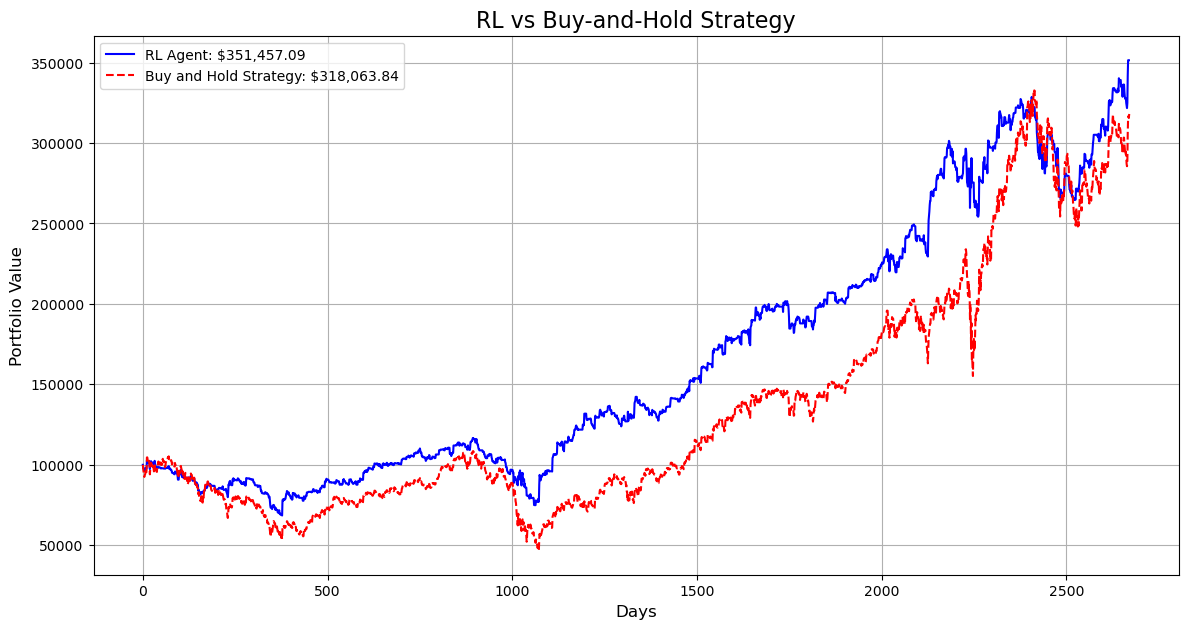

In [136]:
# Buy-and-Hold cumulative portfolio value
buy_and_hold_returns = buy_and_hold_cumulative(gspc)

# Get the final portfolio values for both strategies
rl_final_portfolio_value = rl_portfolio_values[-1]
buy_and_hold_final_portfolio_value = buy_and_hold_returns[-1]

# Plot the comparison
plt.figure(figsize=(14, 7))

# Plot RL strategy portfolio values
plt.plot(rl_portfolio_values, label=f"RL Agent: ${rl_final_portfolio_value:,.2f}", color='blue')

# Plot Buy-and-Hold strategy portfolio values
plt.plot(buy_and_hold_returns, label=f"Buy and Hold Strategy: ${buy_and_hold_final_portfolio_value:,.2f}", color='red', linestyle='--')

# Add titles, labels, and grid
plt.title("RL vs Buy-and-Hold Strategy", fontsize=16)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True)

# Display the legend with final portfolio values
plt.legend()

# Show the plot
plt.show()


In [121]:
# Retrieve the trade log
trade_log = env.get_trade_log()

# Print the trade log
print(trade_log)


      step       date action     shares        price        balance
0        0 2000-02-08    Buy  69.000000  1441.719971     521.322021
1        1 2000-02-09   Sell  68.950199  1411.709961   97859.004854
2        2 2000-02-11    Buy  32.000000  1387.119995   53471.165010
3        3 2000-02-18   Sell  23.756708  1346.089966   85449.831188
4        4 2000-02-25    Buy  27.000000  1333.359985   49449.111583
...    ...        ...    ...        ...          ...            ...
1964  2664 2023-10-27   Sell  10.715303  4117.370117   48974.738069
1965  2665 2023-10-30    Buy   2.000000  4166.819824   40641.098421
1966  2666 2023-11-13    Buy   2.000000  4411.549805   31817.998811
1967  2667 2023-11-29   Sell  70.241394  4550.580078  351457.085372
1968  2669 2023-12-06    Buy  13.000000  4549.339844  292315.667403

[1969 rows x 6 columns]


In [122]:
# Number of Buy and Sell actions
trade_summary = trade_log['action'].value_counts()
print("Trade Summary (Buy/Sell):")
print(trade_summary)

# Total number of shares bought and sold
total_shares_bought = trade_log[trade_log['action'] == 'Buy']['shares'].sum()
total_shares_sold = trade_log[trade_log['action'] == 'Sell']['shares'].sum()

print(f"Total Shares Bought: {total_shares_bought}")
print(f"Total Shares Sold: {total_shares_sold}")

# Average price at which the agent bought and sold
avg_buy_price = trade_log[trade_log['action'] == 'Buy']['price'].mean()
avg_sell_price = trade_log[trade_log['action'] == 'Sell']['price'].mean()

print(f"Average Buy Price: {avg_buy_price}")
print(f"Average Sell Price: {avg_sell_price}")


Trade Summary (Buy/Sell):
action
Sell    992
Buy     977
Name: count, dtype: int64
Total Shares Bought: 36283.0
Total Shares Sold: 36270.0
Average Buy Price: 1988.7074393171858
Average Sell Price: 1914.1839709128103


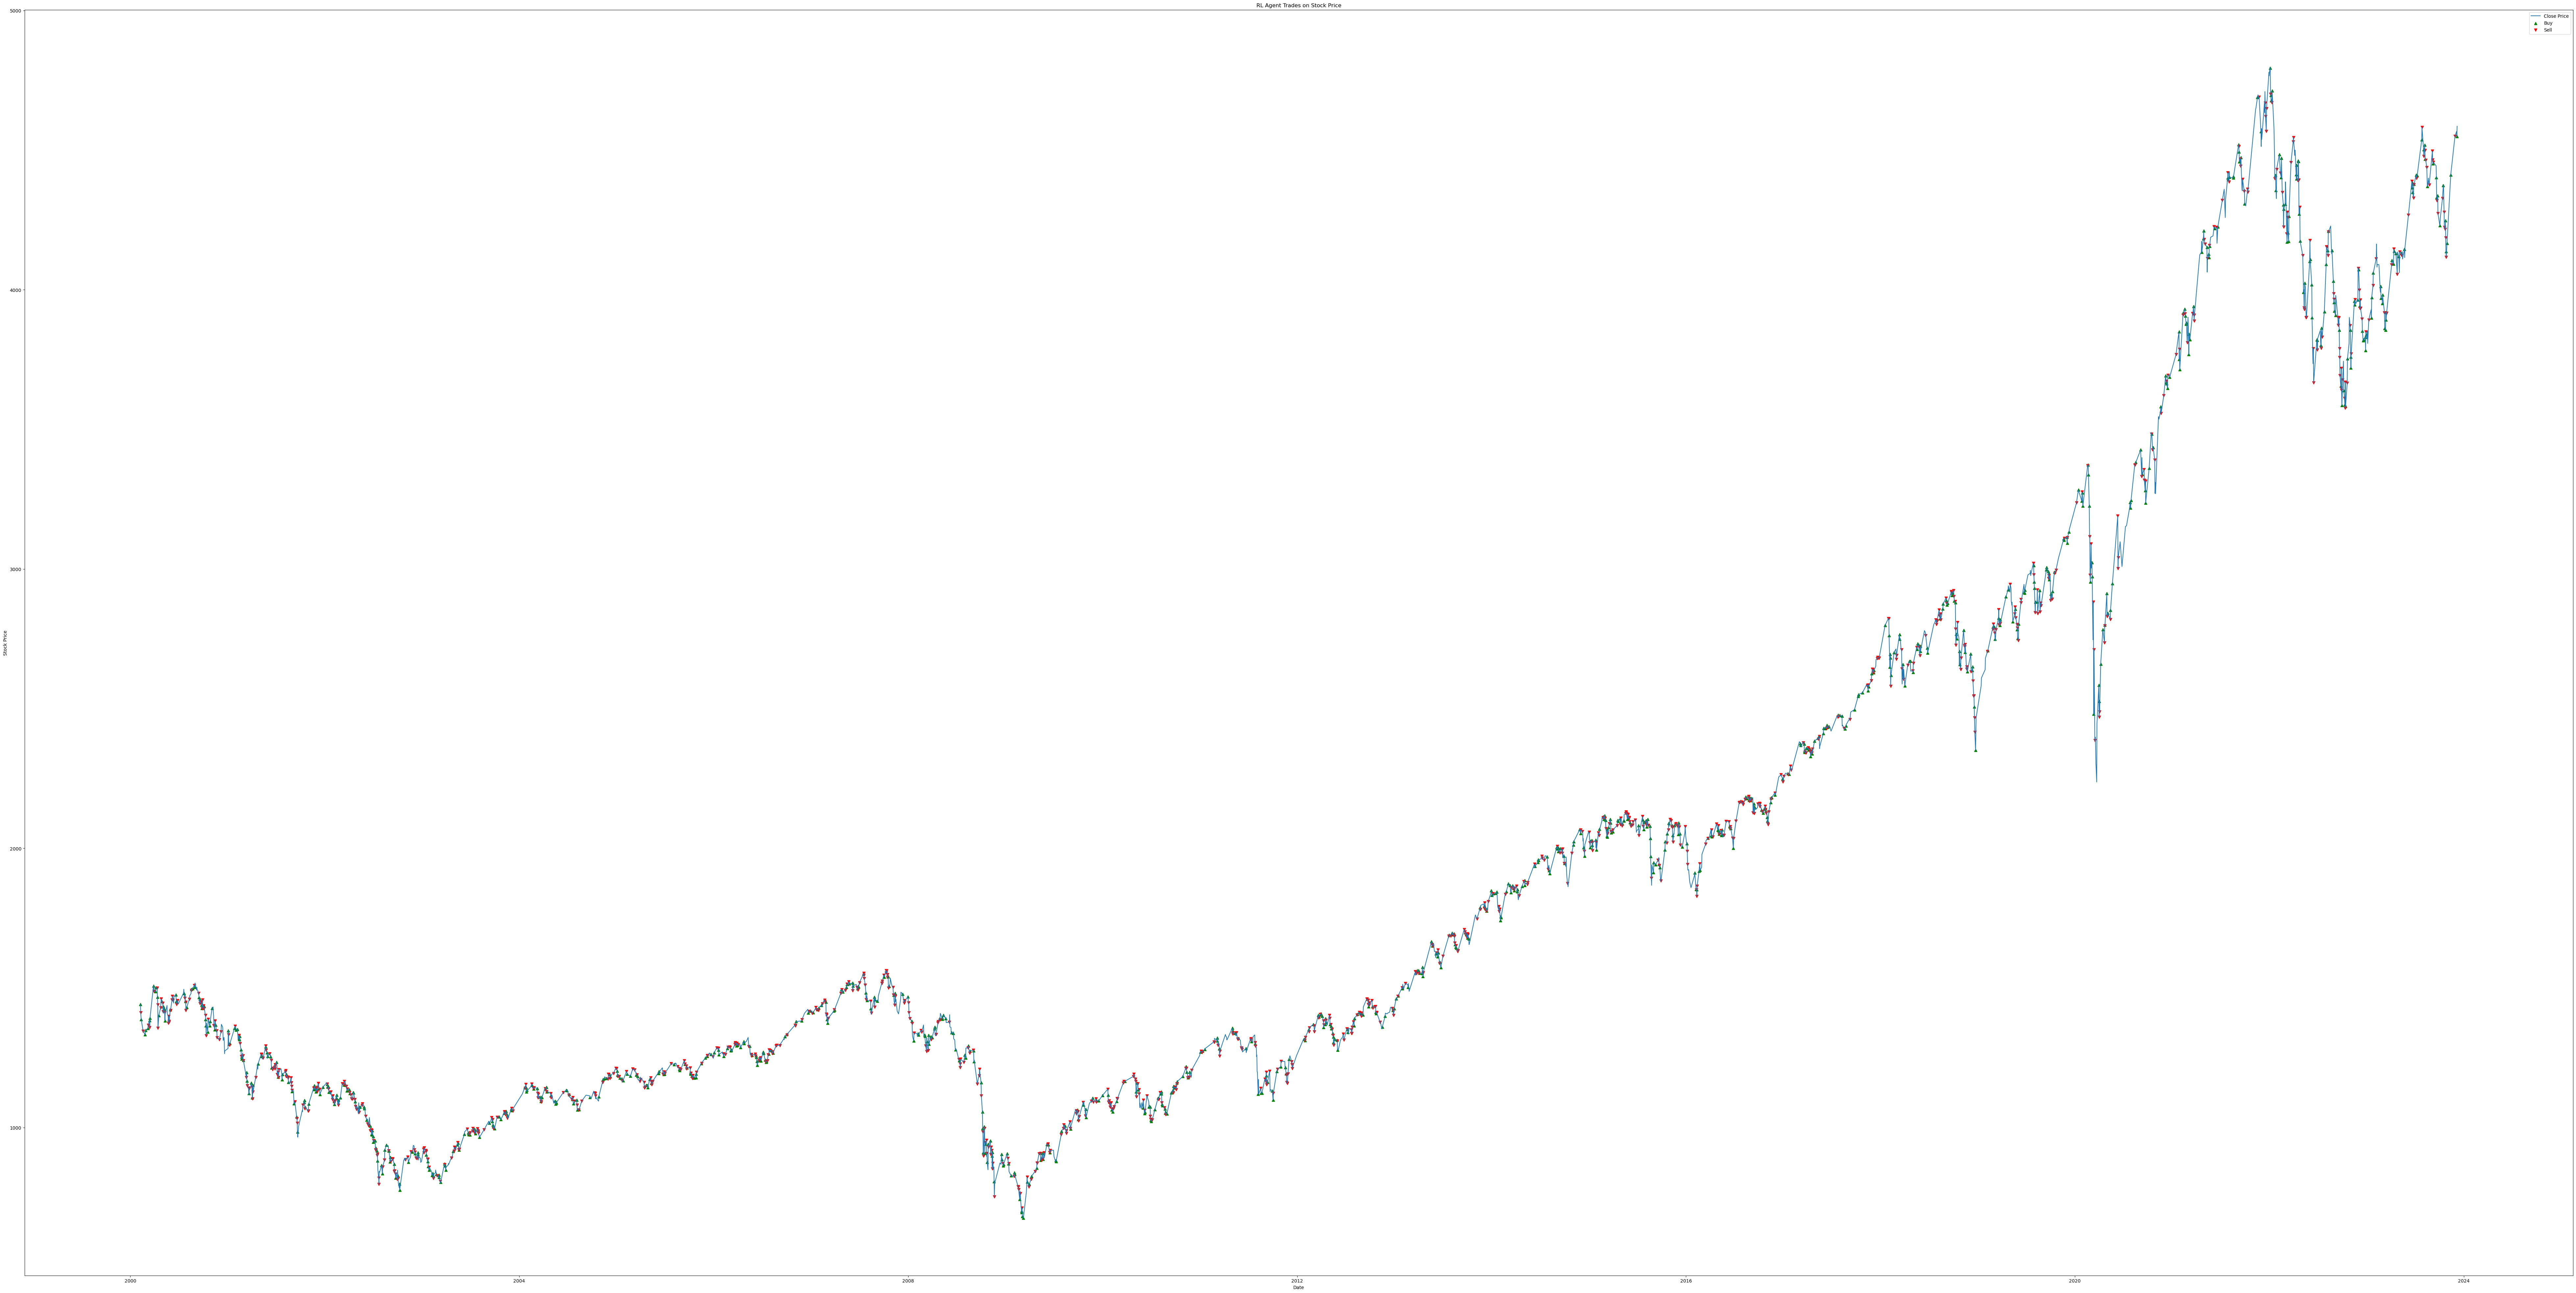

In [124]:
import matplotlib.pyplot as plt

# Plot the stock price
plt.figure(figsize=(100, 50))
plt.plot(gspc.index, gspc['Close'], label='Close Price')

# Plot Buy actions
buy_trades = trade_log[trade_log['action'] == 'Buy']
plt.scatter(gspc.index[buy_trades['step']], buy_trades['price'], color='green', label='Buy', marker='^', alpha=1)

# Plot Sell actions
sell_trades = trade_log[trade_log['action'] == 'Sell']
plt.scatter(gspc.index[sell_trades['step']], sell_trades['price'], color='red', label='Sell', marker='v', alpha=1)

# Titles and labels
plt.title('RL Agent Trades on Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


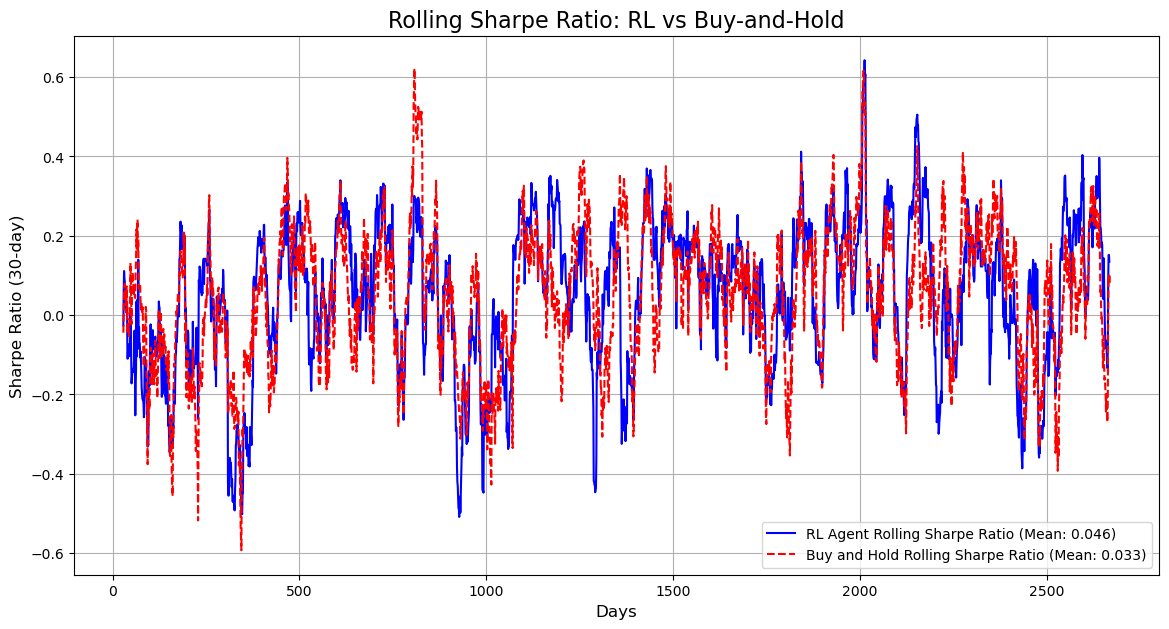

In [142]:
# Calculate Sharpe Ratio using this function
def calculate_sharpe_ratio(returns, window=30):
    rolling_mean = pd.Series(returns).rolling(window).mean()
    rolling_std = pd.Series(returns).rolling(window).std()
    sharpe_ratio = rolling_mean / rolling_std
    return sharpe_ratio

# Calculate mean Sharpe ratio using this function 
def calculate_mean_sharpe_ratio(returns, risk_free_rate=0.0):
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    sharpe_ratio = (mean_return - risk_free_rate) / std_return
    return sharpe_ratio

# Convert portfolio values to returns
rl_returns = np.diff(rl_portfolio_values) / rl_portfolio_values[:-1]
buy_and_hold_returns_series = np.diff(buy_and_hold_returns) / buy_and_hold_returns[:-1]

# Calculate rolling Sharpe ratios (30-day window)
rl_rolling_sharpe = calculate_sharpe_ratio(rl_returns)
buy_and_hold_rolling_sharpe = calculate_sharpe_ratio(buy_and_hold_returns_series)

rl_mean_sharpe = calculate_mean_sharpe_ratio(rl_returns)
buy_and_hold_mean_sharpe = calculate_mean_sharpe_ratio(buy_and_hold_returns_series)

# Plot the rolling Sharpe ratio
plt.figure(figsize=(14, 7))

# Plot RL strategy rolling Sharpe ratio
plt.plot(rl_rolling_sharpe, label=f"RL Agent Rolling Sharpe Ratio (Mean: {rl_mean_sharpe:.3f})", color='blue')

# Plot Buy-and-Hold strategy rolling Sharpe ratio
plt.plot(buy_and_hold_rolling_sharpe, label=f"Buy and Hold Rolling Sharpe Ratio (Mean: {buy_and_hold_mean_sharpe:.3f})", color='red', linestyle='--')

# Add titles, labels, and grid
plt.title("Rolling Sharpe Ratio: RL vs Buy-and-Hold", fontsize=16)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Sharpe Ratio (30-day)", fontsize=12)
plt.grid(True)

# Display the legend with mean Sharpe ratios
plt.legend()

# Show the plot
plt.show()


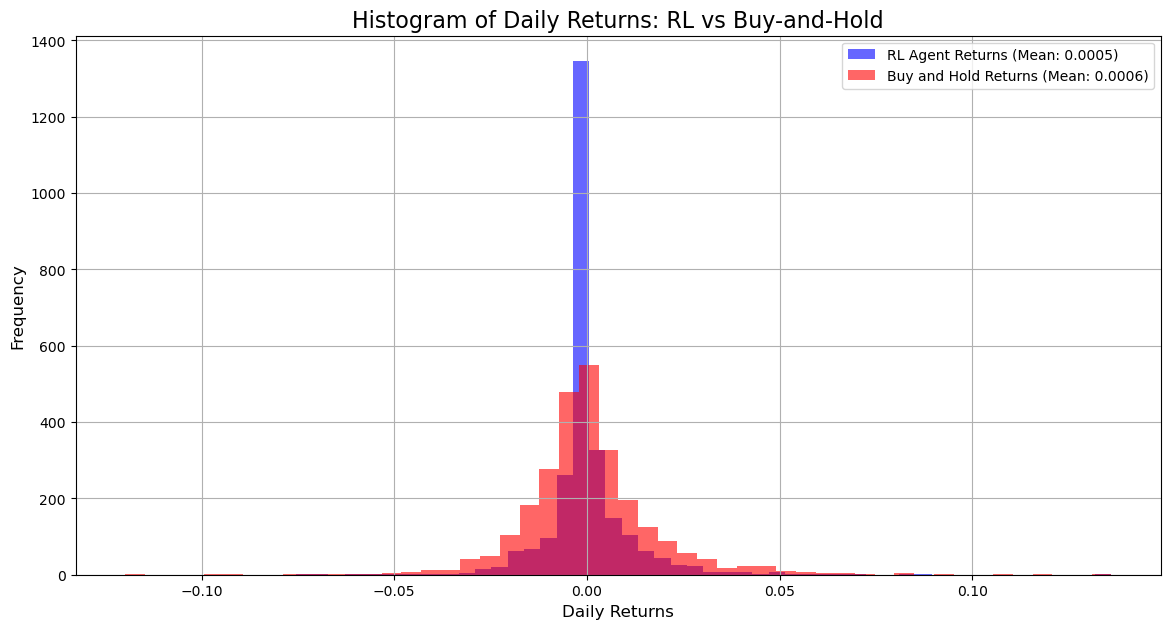

In [144]:
# Calculate the mean daily returns for both strategies
rl_mean_return = np.mean(rl_returns)
buy_and_hold_mean_return = np.mean(buy_and_hold_returns_series)

# Plot histogram of daily returns for RL and Buy-and-Hold strategies
plt.figure(figsize=(14, 7))

# Plot RL strategy returns with mean return in the label
plt.hist(rl_returns, bins=50, alpha=0.6, color='blue', label=f"RL Agent Returns (Mean: {rl_mean_return:.4f})")

# Plot Buy-and-Hold strategy returns with mean return in the label
plt.hist(buy_and_hold_returns_series, bins=50, alpha=0.6, color='red', label=f"Buy and Hold Returns (Mean: {buy_and_hold_mean_return:.4f})")

# Add titles, labels, and grid
plt.title("Histogram of Daily Returns: RL vs Buy-and-Hold", fontsize=16)
plt.xlabel("Daily Returns", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)

# Display the legend with mean daily returns
plt.legend()

# Show the plot
plt.show()


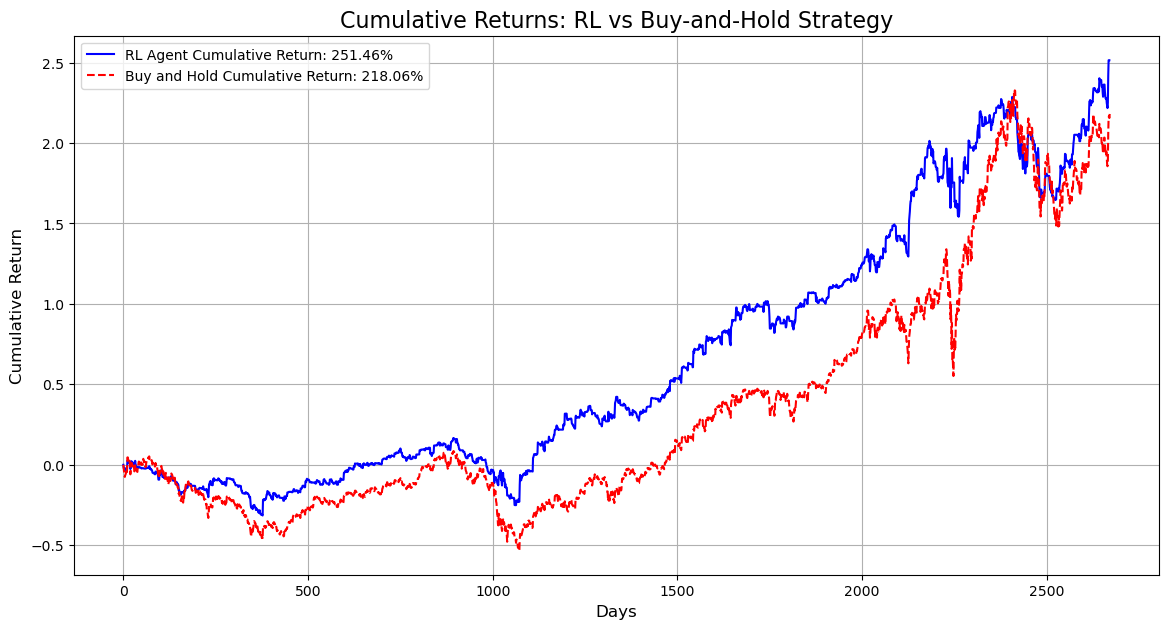

In [148]:
# Cumulative returns calculation
initial_balance = 100000
rl_cumulative_returns = [(x - initial_balance) / initial_balance for x in rl_portfolio_values]
buy_and_hold_cumulative_returns = [(x - initial_balance) / initial_balance for x in buy_and_hold_returns]

# Get the final cumulative return values for both strategies
rl_final_return = rl_cumulative_returns[-1]
buy_and_hold_final_return = buy_and_hold_cumulative_returns[-1]

# Plot cumulative returns
plt.figure(figsize=(14, 7))

# Plot RL cumulative returns
plt.plot(rl_cumulative_returns, label=f"RL Agent Cumulative Return: {rl_final_return:.2%}", color='blue')

# Plot Buy-and-Hold cumulative returns
plt.plot(buy_and_hold_cumulative_returns, label=f"Buy and Hold Cumulative Return: {buy_and_hold_final_return:.2%}", color='red', linestyle='--')

# Add titles, labels, and grid
plt.title("Cumulative Returns: RL vs Buy-and-Hold Strategy", fontsize=16)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.grid(True)

# Display legend with final cumulative return values
plt.legend()

# Show the plot
plt.show()


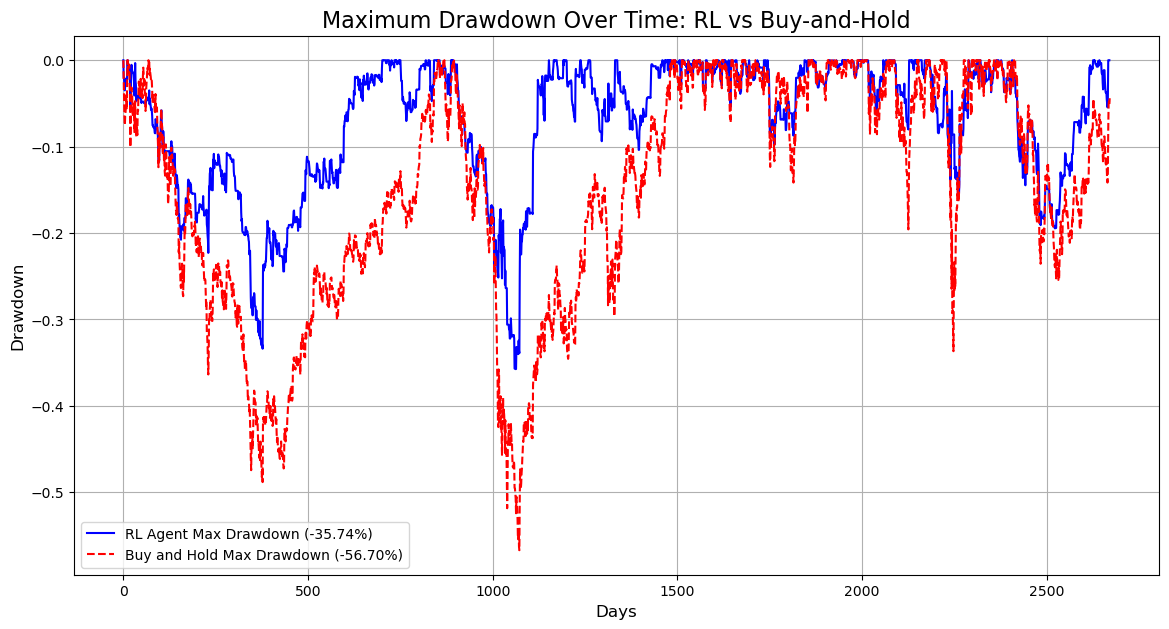

In [145]:
def calculate_maximum_drawdown(portfolio_values):
    running_max = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - running_max) / running_max
    max_drawdown = np.min(drawdown)
    return drawdown, max_drawdown

# Calculate maximum drawdowns
rl_drawdown, rl_max_drawdown = calculate_maximum_drawdown(rl_portfolio_values)
buy_and_hold_drawdown, buy_and_hold_max_drawdown = calculate_maximum_drawdown(buy_and_hold_returns)

# Plot the maximum drawdown comparison
plt.figure(figsize=(14, 7))
plt.plot(rl_drawdown, label=f"RL Agent Max Drawdown ({rl_max_drawdown:.2%})", color='blue')
plt.plot(buy_and_hold_drawdown, label=f"Buy and Hold Max Drawdown ({buy_and_hold_max_drawdown:.2%})", color='red', linestyle='--')

plt.title("Maximum Drawdown Over Time: RL vs Buy-and-Hold", fontsize=16)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Drawdown", fontsize=12)
plt.grid(True)
plt.legend()

plt.show()


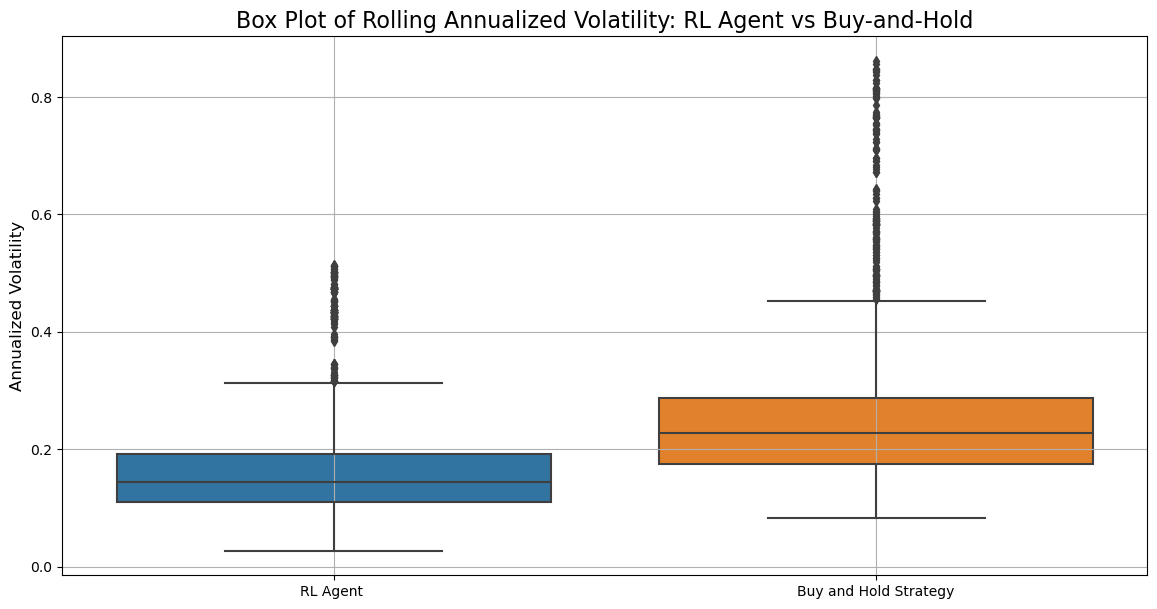

In [132]:
# Calculate annualized volatility
rl_daily_returns = np.diff(rl_portfolio_values) / rl_portfolio_values[:-1]
buy_and_hold_daily_returns = np.diff(buy_and_hold_returns) / buy_and_hold_returns[:-1]

def calculate_rolling_annualized_volatility(returns, window=30, trading_days=252):
    # Calculate rolling standard deviation
    rolling_volatility = pd.Series(returns).rolling(window).std() * np.sqrt(trading_days)
    return rolling_volatility

# Calculate rolling annualized volatility for RL and Buy-and-Hold strategies
rl_rolling_annualized_volatility = calculate_rolling_annualized_volatility(rl_daily_returns)
buy_and_hold_rolling_annualized_volatility = calculate_rolling_annualized_volatility(buy_and_hold_daily_returns)

import seaborn as sns

# Create a dataframe for easier plotting
import pandas as pd

volatility_data = pd.DataFrame({
    "RL Agent ": rl_rolling_annualized_volatility,
    "Buy and Hold Strategy": buy_and_hold_rolling_annualized_volatility
})

# Drop NaN values
volatility_data.dropna(inplace=True)

# Create a box plot using seaborn
plt.figure(figsize=(14, 7))
sns.boxplot(data=volatility_data)

# Add titles and labels
plt.title("Box Plot of Rolling Annualized Volatility: RL Agent vs Buy-and-Hold", fontsize=16)
plt.ylabel("Annualized Volatility", fontsize=12)
plt.grid(True)

# Display the plot
plt.show()



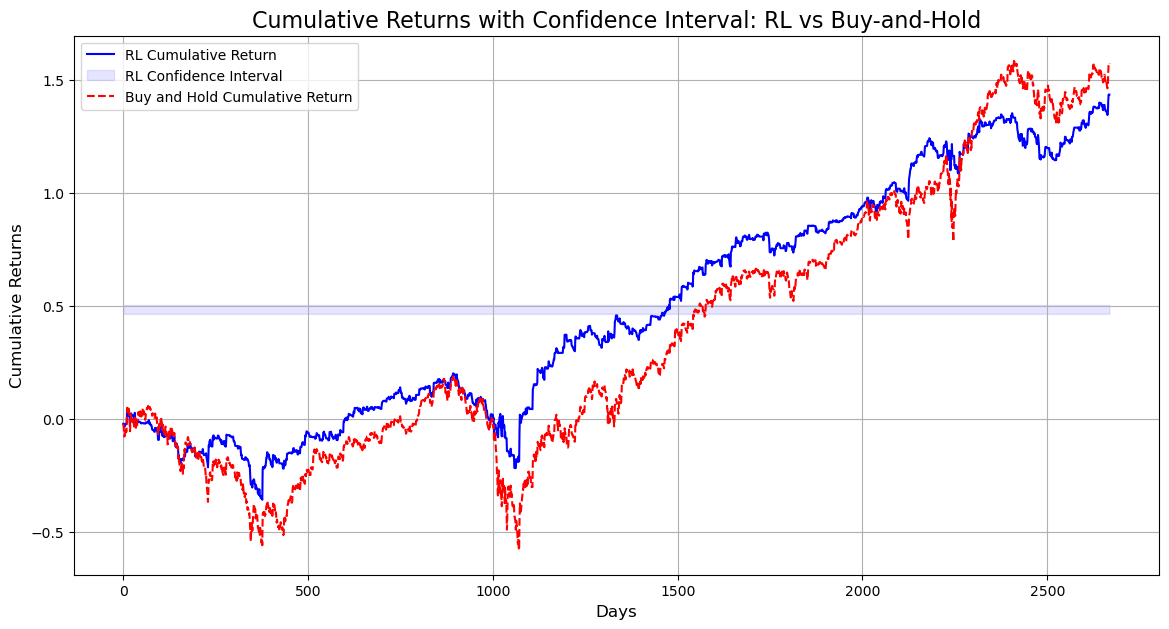

In [133]:
# Create a function to calculate a confidence interval
def calculate_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std = np.std(data)
    margin_of_error = 1.95 * std / np.sqrt(len(data))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return lower_bound, upper_bound

# Cumulative returns calculation
rl_cumulative_returns = np.cumsum(rl_daily_returns)
buy_and_hold_cumulative_returns = np.cumsum(buy_and_hold_daily_returns)

# Calculate the confidence interval for RL strategy
rl_lower_bound, rl_upper_bound = calculate_confidence_interval(rl_cumulative_returns)

# Plot cumulative returns with confidence interval
plt.figure(figsize=(14, 7))

plt.plot(rl_cumulative_returns, label="RL Cumulative Return", color='blue')
plt.fill_between(range(len(rl_cumulative_returns)), rl_lower_bound, rl_upper_bound, color='blue', alpha=0.1, label="RL Confidence Interval")
plt.plot(buy_and_hold_cumulative_returns, label="Buy and Hold Cumulative Return", color='red', linestyle='--')

plt.title("Cumulative Returns with Confidence Interval: RL vs Buy-and-Hold", fontsize=16)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


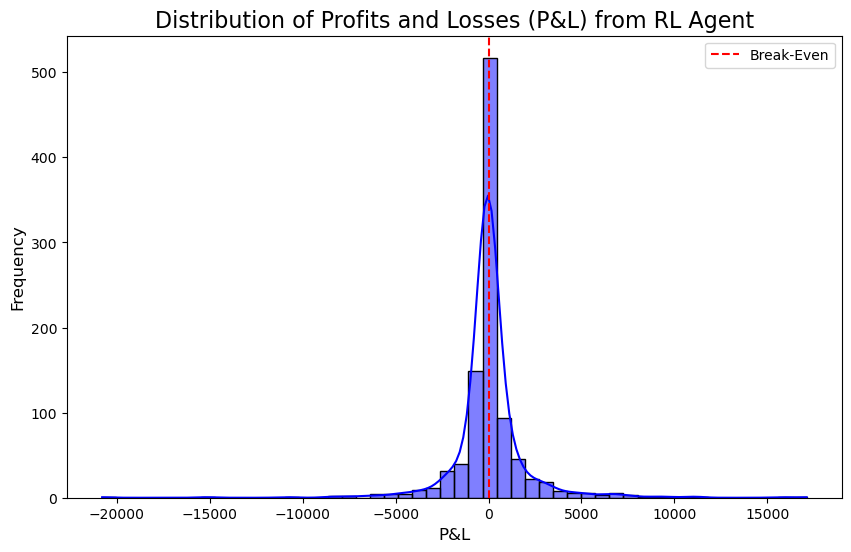

In [146]:
# Calculate P&L for each trade made by the RL agent
trade_pl = []

for i in range(1, len(env.trade_log)):
    if env.trade_log[i]['action'] == 'Sell':
        buy_price = env.trade_log[i - 1]['price']
        sell_price = env.trade_log[i]['price']
        shares_traded = env.trade_log[i]['shares']
        profit = (sell_price - buy_price) * shares_traded
        trade_pl.append(profit)

# Plot the distribution of profits and losses (P&L)
plt.figure(figsize=(10, 6))
sns.histplot(trade_pl, bins=50, kde=True, color="blue")
plt.axvline(0, color='red', linestyle='--', label='Break-Even')
plt.title("Distribution of Profits and Losses (P&L) from RL Agent", fontsize=16)
plt.xlabel("P&L", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()
